# Simulation of Cold Start Experiments

In [1]:
# import packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import argparse
import math
from scipy import stats
import os

In [2]:
#PID system for the cold start (current practice on Platform O), which uniformaly increases bids of all new ads,
#then let PID system adaptively changes bids.
def PID_sys(current_cpc_, target_cpc_, current_ecpc_):
    #Here we use a simplified version of PID: (1) k_I=p_D=0, (2) set current_ecpc = current_cpc
    #which means this simplified PID use an exponential smoothing to update bids
    
    k_p = 0.4
    
    #equivalent version:
    #error = target_cpc_ - current_ecpc_
    #current_cpc_updated = current_cpc_ + k_p*error
    current_cpc_updated = k_p * target_cpc_ + (1-k_p) * current_cpc_
    return current_cpc_updated


#Define context generating function.
gender_pdf = np.array([0.5, 0.5])#marginal distribution of gender. [male, female]
location_pdf = np.array([0.22, 0.46, 0.32])#marginal distribution of city level. [large city, medium city, small city]
age_seg_pdf = np.array([0.46, 0.34, 0.20])#marginal distribution of age. [small age, middle age, large age]
dim_context  = int(np.shape(gender_pdf)[0]+np.shape(location_pdf)[0]+np.shape(age_seg_pdf)[0] + 1)
def context_generate(gender_ratio = gender_pdf, loc_ratio = location_pdf, age_ratio = age_seg_pdf):
    a = np.random.multinomial(1, gender_pdf, size=1)
    b = np.random.multinomial(1, location_pdf, size=1)
    c = np.random.multinomial(1, age_ratio, size=1)
    return np.concatenate((a, b, c, 1), axis=None)


#Load sampled data and define ad-campaign generating function.
#load joint information of ctr fixed effect coefficient, and target bid (CPC)
ctr_bid_np = np.load('ctr_bid_data.npy')
#note the first 200 rows are marure ads and last 100 rows are new ads
def generate_ad(n, new_raito = 0.30, dim_context = dim_context, data = ctr_bid_np):
    #n is the total number of ads, new_raito is ratio of new ads
    num_new_ad = int(n*new_raito)
    num_mature_ad = n - num_new_ad
    sampled_ctr = data[:, 0]
    sampled_cpc = data[:, 1]
    
    #initialize output data: 
    is_new_index = np.zeros(n)
    target_cpc = np.zeros(n)
    coefficient_ctr_model = np.zeros([n, dim_context])
    
    #generate bid, true CTR model
    for i in range(n):
        index = 0
        if i < num_mature_ad:
            is_new_index[i] = 0
            index = np.random.choice(np.arange(0,200))
        else:
            is_new_index[i] = 1
            index = np.random.choice(np.arange(200,300)) 
        target_cpc[i] = sampled_cpc[index]
        coefficient_ctr_model[i, 0:-1] = np.random.uniform(-0.05,0.05,dim_context-1)
        coefficient_ctr_model[i, -1] = sampled_ctr[index]
    return np.int32(is_new_index), target_cpc, coefficient_ctr_model

# Hyperparameter Setting

In [3]:
# hyperparameters settings. Notice that this system is based on first price auction and CPC,
# which are consistent with paper modeling assumption in Section 3
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()

#Default cold start parameters - the cold start value = reward*I(clicks>=target_click)
parser.add_argument('--total_ads', type=int, default=1000, help='total number of ads for simulation')
parser.add_argument('--new_ad_ratio', type=float, default=0.3, help='ratio of new ads')
parser.add_argument('--total_pv', type=int, default=3000000, help='loaded total page views in one cold start horizon for simulation')
parser.add_argument('--reward', type=float, default=400000, help='reward of cold start')
parser.add_argument('--target_click', type=int, default=1000, help='target click')
parser.add_argument('--alpha', type=float, default=1e-3, help='target click/total_pv')
#If one wants to change total_ads, it is better to proportionally change total_pv to balance the two-side market


#Others parameters
parser.add_argument('--budget_limit', type=int, default=5e5, help='set an uniform budget limit on ads')
parser.add_argument('--cs', type=int, default=0, help='if using SBL-DMD in parallel simulation')
parser.add_argument('--stepsize', type=float, default=30, help='step size of DMD')
parser.add_argument('--PID_cycle', type=int, default=100000, help='after every # pvs, update PID')



#Parameters about experiments - sampling rate
parser.add_argument('--ad_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')
parser.add_argument('--pv_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')



opt = parser.parse_args()
opt.alpha  = opt.target_click/opt.total_pv

## Module I: Two parallel simulations, one implementing the baseline ad delivery algorithm (i.e., the PID-controller driven bidding strategy) and the other implementing the Shadow Bidding with Learing and Dual Mirror Descent (SBL-DMD) Algorithm.

In [4]:
is_new_index, target_bid_price, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                          new_raito = opt.new_ad_ratio)

### I.1 PID as a baseline

In [5]:
opt.cs = 0 #using PID


#Initialize the simulation
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1] + 0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]
#Initialize PID system
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click
      

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc, target_cpc, current_ecpc)
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc
    
   

In [6]:
#Output simulation results
total_clicks_pid = np.copy(total_clicks)
total_impressions_pid = np.copy(total_impressions)
total_cost_pid = np.copy(total_cost)
final_bid_pid = np.copy(current_cpc)
final_lambda_pid = np.copy(lambda_)

print('================================================')
print('Revenue:', np.sum(total_cost))
PO_c = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in control, take Cold Start Success Rate as example
print('Cold Start Success Rate:',PO_c)
PO_rev_c = np.sum(total_cost)
print('================================================')


#Other metrics such as L1 reward, and objective value
#print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
#print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
#print('================================================')




Revenue: 77732015.87517467
Cold Start Success Rate: 0.006666666666666667


### I.2 SBL-DMD

In [7]:
opt.cs = 1#using SBL-DMD

#initialize the simulation
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    lambda_ = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click
    
            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    

In [8]:
#Simulation results
total_clicks_sbl = np.copy(total_clicks)
total_impressions_sbl = np.copy(total_impressions)
total_cost_sbl = np.copy(total_cost)
final_bid_sbl = np.copy(current_cpc)
final_lambda_sbl = np.copy(lambda_)

print('================================================')
print('Revenue:', np.sum(total_cost))
PO_t = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in treatment, take Cold Start Success Rate as example
print('Cold Start Success Rate:',PO_t)
PO_rev_t = np.sum(total_cost)
print('================================================')
#print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
#print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))


Revenue: 76641665.91508968
Cold Start Success Rate: 0.06666666666666667


In [9]:
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))

Ground True Effect on Cold Start Success Rate: 0.06
Ground True (Relative) Effect on Revenue: -1.4%


# Module II: The Ad-side and UV-side experiment designs.

### II.1 Ad-side experiments

In [10]:
#Default: opt.ad_treatment_ratio = 0.4
print('Ad-side experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    


#initialization
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control + lambda_*is_new_treatment
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0

    if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
        max_index = np.random.choice(treatment_new_ad_index, 1)[0]
    else:
        max_index = np.argmax(ecpm, axis=0)

    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    lambda_ += opt.stepsize*opt.alpha
    lambda_[max_index] -= opt.stepsize*pCTR[max_index]

    #upper bound the bounus, and mature ads with 0 bonus
    lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
    lambda_ = np.maximum(lambda_, 0)*is_new_treatment

    #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
    lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i%opt.PID_cycle==(opt.PID_cycle-1):
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

   

Ad-side experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120


In [11]:
#Simulation results
total_clicks_ad_side = np.copy(total_clicks)
total_impressions_ad_side = np.copy(total_impressions)
total_cost_ad_side = np.copy(total_cost)
final_bid_ad_side = np.copy(current_cpc)
final_lambda_ad_side = np.copy(lambda_)
is_new_treatment_ad_side = np.copy(is_new_treatment)
is_new_control_ad_side = np.copy(is_new_control)

print('================================================')
print('Revenue: In this ad-side design, revenue (over all auctions) diff between treatment and control cannot be identified because new ads in both conditions join all auctions.')
#print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks*is_new_treatment, opt.target_click)))
#print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks*is_new_control, opt.target_click)))
#print('================================================')
a = (total_clicks*is_new_treatment>=opt.target_click).sum()/is_new_treatment.sum()
b = (total_clicks*is_new_control>=opt.target_click).sum()/is_new_control.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('================================================')
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))

Revenue: In this ad-side design, revenue (over all auctions) diff between treatment and control cannot be identified because new ads in both conditions join all auctions.
Cold Start Success Rate in Treatment: 0.13333333333333333
Cold Start Success Rate in Control: 0.016666666666666666
Estimator of Effect on Cold Start Success Rate:  0.11666666666666667
Ground True Effect on Cold Start Success Rate: 0.06
Overestimate/underestimate by: 94.4%


### II.2 UV side experiments

In [12]:
#Default: opt.pv_treatment_ratio = 0.4

print('UV-side experiment')

#initialization
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)
scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)

total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs
total_clicks_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs
total_impressions_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
total_cost_t = np.zeros(opt.total_ads)
total_cost_c = np.zeros(opt.total_ads)
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_index[i]==1:
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                    p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if uv_condition == 't':
        current_bid_np = target_cpc + lambda_*is_new_index
    elif uv_condition == 'c':
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index
    else:
        current_bid_np = np.copy(target_cpc)
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    if uv_condition == 't':
        current_bid_np -= 10000*np.greater(total_cost_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
    elif uv_condition == 'c':
        current_bid_np -= 10000*np.greater(total_cost_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
    
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    if uv_condition == 't':
        total_impressions_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_c[max_index] += 1
    #get the click feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_t[max_index] += 1
            total_cost_t[max_index] += target_cpc[max_index]
        elif uv_condition == 'c':
            total_clicks_c[max_index] += 1
            total_cost_c[max_index] += target_cpc[max_index]
    
    
    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if uv_condition == 't':
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]
        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        lambda_ = np.less(total_clicks_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
    if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_index
    if uv_condition == 'c':
        current_cpc = np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc



UV-side experiment


In [13]:
#store the simulation results
total_clicks_uv_side = np.copy(total_clicks)
total_impressions_uv_side = np.copy(total_impressions)
total_cost_uv_side = np.copy(total_cost)
final_bid_uv_side = np.copy(current_cpc)
final_lambda_uv_side = np.copy(lambda_)

print('================================================')
print('Revenue in Treatment with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_t))
print('Revenue in Control with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_c))
print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_t*is_new_index, opt.pv_treatment_ratio*opt.target_click)))
print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_c*is_new_index, opt.pv_treatment_ratio*opt.target_click)))
print('================================================')
a = (total_clicks_t*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
b = (total_clicks_c*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('================================================')
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))
print('================================================')
print('Estimator of (Relative) Effect on Revenue:', '{:.1%}'.format(np.sum(total_cost_t)/np.sum(total_cost_c)-1))
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))


Revenue in Treatment with  0.4  of total impressions: 30403596.54056247
Revenue in Control with  0.4  of total impressions: 30807270.233657867
L1-Cold Start Reward in Treatment: 11244400.0
L1-Cold Start Reward in Control: 6549600.0
Cold Start Success Rate in Treatment: 0.03666666666666667
Cold Start Success Rate in Control: 0.07333333333333333
Estimator of Effect on Cold Start Success Rate:  -0.03666666666666667
Ground True Effect on Cold Start Success Rate: 0.06
Overestimate/underestimate by: -161.1%
Estimator of (Relative) Effect on Revenue: -1.3%
Ground True (Relative) Effect on Revenue: -1.4%


# Module III: Two-side field experiment

In [14]:
#Default: opt.ad_treatment_ratio = 0.4
#Default: opt.pv_treatment_ratio = 0.4

print('Two side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (PID)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)
new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
target_cpc = np.copy(target_bid_price)
scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)
mature_ad_index = np.where(is_new_index==0)[0]

total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
total_cost_two_t = np.zeros(opt.total_ads)
total_cost_two_c = np.zeros(opt.total_ads)

coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

            
#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
    if uv_condition == 't':
        #block ads in control condition by setting bid=-10000
        current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
    elif uv_condition == 'c':
        #block ads in treatment condition
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
    else:
        current_bid_np = current_bid_np - 10000*is_new_control - 10000*is_new_treatment

    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    if uv_condition == 't':
        current_bid_np -= 10000*np.greater(total_cost_two_t, opt.pv_treatment_ratio*opt.budget_limit)
    elif uv_condition == 'c':
        current_bid_np -= 10000*np.greater(total_cost_two_c, opt.pv_treatment_ratio*opt.budget_limit)

    ecpm = pCTR * current_bid_np
    if uv_condition == 't':
        ecpm[control_new_ad_index] = np.random.choice(ecpm[mature_ad_index], int(is_new_control.sum()))
    elif uv_condition == 'c':
        ecpm[treatment_new_ad_index] = np.random.choice(ecpm[mature_ad_index], int(is_new_treatment.sum()))

    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    if uv_condition == 't':
        total_impressions_two_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_two_c[max_index] += 1
        
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_two_t[max_index] += 1
            total_cost_two_t[max_index] += target_cpc[max_index]
        elif uv_condition == 'c':
            total_clicks_two_c[max_index] += 1
            total_cost_two_c[max_index] += target_cpc[max_index]


    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    if uv_condition == 't':
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
        lambda_ = np.maximum(lambda_, 0)*is_new_treatment

        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    if uv_condition == 'c':
        current_cpc = np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc

   

Two side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (PID) 120


In [15]:
#Simulation results
total_clicks_two_side = np.copy(total_clicks)
total_impressions_two_side = np.copy(total_impressions)
total_cost_two_side = np.copy(total_cost)
final_bid_two_side = np.copy(current_cpc)
final_lambda_two_side = np.copy(lambda_)
is_new_treatment_two_side = np.copy(is_new_treatment)
is_new_control_two_side = np.copy(is_new_control)


print('================================================')
print('Revenue in Treatment with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_t))
print('Revenue in Control with ', opt.pv_treatment_ratio, ' of total impressions:', np.sum(total_cost_two_c))
#print('L1-Cold Start Reward in Treatment:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_t*is_new_treatment, opt.pv_treatment_ratio*opt.target_click)))
#print('L1-Cold Start Reward in Control:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_c*is_new_control, opt.pv_treatment_ratio*opt.target_click)))
#print('================================================')
a = (total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum()
b = (total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum()
print('Cold Start Success Rate in Treatment:', a)
print('Cold Start Success Rate in Control:', b)
print('================================================')
print('Estimator of Effect on Cold Start Success Rate: ', a-b)
print('Ground True Effect on Cold Start Success Rate:', PO_t-PO_c)
print('Overestimate/underestimate by:', '{:.1%}'.format((a-b)/(PO_t-PO_c)-1))
print('================================================')
print('Estimator of (Relative) Effect on Revenue:', '{:.1%}'.format(np.sum(total_cost_two_t)/np.sum(total_cost_two_c)-1))
print('Ground True (Relative) Effect on Revenue:', '{:.1%}'.format(PO_rev_t/PO_rev_c-1))

Revenue in Treatment with  0.4  of total impressions: 30704102.264813915
Revenue in Control with  0.4  of total impressions: 30939358.463546842
Cold Start Success Rate in Treatment: 0.13333333333333333
Cold Start Success Rate in Control: 0.041666666666666664
Estimator of Effect on Cold Start Success Rate:  0.09166666666666667
Ground True Effect on Cold Start Success Rate: 0.06
Overestimate/underestimate by: 52.8%
Estimator of (Relative) Effect on Revenue: -0.8%
Ground True (Relative) Effect on Revenue: -1.4%


# Module IV: Replications for hypothesis testing

In [20]:
replication_times = 20
opt = parser.parse_args()
opt.alpha  = opt.target_click/opt.total_pv
opt.ad_treatment_ratio = 0.4
opt.pv_treatment_ratio = 0.4


#List to store simulation results
true_cs_value = []
ad_side_cs_estimator = []
uv_side_cs_estimator = []
two_side_cs_estimator = []
true_rev_value = []
uv_side_rev_estimator = []
two_side_rev_estimator = []

In [21]:
is_new_index, target_bid_price, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                    new_raito = opt.new_ad_ratio)
for rep_index in range(replication_times):
    print('===========================================================')
    print('Replication time: ', rep_index+1)
    is_new_index, target_bid_price, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                    new_raito = opt.new_ad_ratio)

    
    print('Running PID benchmark')
    opt.cs = 0#using PID
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)
    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]
    current_cpc = np.zeros(opt.total_ads)
    if opt.cs == 0:
        for i in range(opt.total_ads):
            if is_new_index[i]==1:
                current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if opt.cs == 1:
            current_bid_np = target_cpc + lambda_
        else:
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if opt.cs==1:
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            #using PID
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if opt.cs==1:
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
        if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc, target_cpc, current_ecpc)
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    PO_c = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in control, take Cold Start Success Rate as example
    PO_rev_c = total_cost.sum()

    
    ################
    print('Runnung SBL-DMD benchmark')
    opt.cs = 1#using SBL-DMD
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)
    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]
    current_cpc = np.zeros(opt.total_ads)
    if opt.cs == 0:
        lambda_ = np.zeros(opt.total_ads)
        for i in range(opt.total_ads):
            if is_new_index[i]==1:
                current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if opt.cs == 1:
            current_bid_np = target_cpc + lambda_
        else:
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if opt.cs==1:
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            #using PID
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if opt.cs==1:
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
        if opt.cs==0 and i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    PO_t = (total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum()#potential outcome in treatment, take Cold Start Success Rate as example
    PO_rev_t = total_cost.sum()
    
    true_cs_value.append(PO_t-PO_c)
    true_rev_value.append(PO_rev_t/PO_rev_c-1)
    
    print('Running Ad side randomized experiment')
    is_new_treatment = np.zeros(opt.total_ads)
    is_new_control = np.zeros(opt.total_ads)

    new_ad_index = np.where(is_new_index==1)[0]
    treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                              int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
        is_new_treatment[treatment_new_ad_index[i]] = 1
        is_new_control[control_new_ad_index[i]] = 1
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)


    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_control[i] == 1:
            #new control ads
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

    #simulation starts
    for i in range(opt.total_pv):

        ##########################generate context##########################
        contexts = context_generate()

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.copy(target_cpc)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control + lambda_*is_new_treatment
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0

        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]

        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        #SBL-DMD, using dual mirror descent to update lambda
        lambda_ += opt.stepsize*opt.alpha
        lambda_[max_index] -= opt.stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
        lambda_ = np.maximum(lambda_, 0)*is_new_treatment

        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_

        if i%opt.PID_cycle==(opt.PID_cycle-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_control
        current_cpc = np.less(total_clicks, opt.target_click)*current_cpc + (1- np.less(total_clicks, opt.target_click))*target_cpc

    a = (total_clicks*is_new_treatment>=opt.target_click).sum()/is_new_treatment.sum()
    b = (total_clicks*is_new_control>=opt.target_click).sum()/is_new_control.sum()
    ad_side_cs_estimator.append(a-b)
    
    print('Running UV side randomized experiment')
    scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)
    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_clicks_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs
    total_clicks_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs

    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_impressions_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs
    total_impressions_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs

    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    total_cost_t = np.zeros(opt.total_ads)
    total_cost_c = np.zeros(opt.total_ads)

    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
    new_ad_index = np.where(is_new_index==1)[0]
    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click

    #simulation starts
    for i in range(opt.total_pv):


        ##########################generate context##########################
        contexts = context_generate()
        uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                        p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.zeros(opt.total_ads)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if uv_condition == 't':
            current_bid_np = target_cpc + lambda_*is_new_index
        elif uv_condition == 'c':
            current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index
        else:
            current_bid_np = np.copy(target_cpc)
        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        if uv_condition == 't':
            current_bid_np -= 10000*np.greater(total_cost_t, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index
        elif uv_condition == 'c':
            current_bid_np -= 10000*np.greater(total_cost_c, opt.pv_treatment_ratio*opt.budget_limit)*is_new_index

        ecpm = pCTR * current_bid_np
        #ranking
        max_index = 0
        if uv_condition == 't':
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        if uv_condition == 't':
            total_impressions_t[max_index] += 1
        elif uv_condition == 'c':
            total_impressions_c[max_index] += 1
        #get the click feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]
            if uv_condition == 't':
                total_clicks_t[max_index] += 1
                total_cost_t[max_index] += target_cpc[max_index]
            elif uv_condition == 'c':
                total_clicks_c[max_index] += 1
                total_cost_c[max_index] += target_cpc[max_index]


        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        if uv_condition == 't':
            #SBL-DMD, using dual mirror descent to update lambda
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]
            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_index
            lambda_ = np.maximum(lambda_, 0)*is_new_index
            lambda_ = np.less(total_clicks_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_
        if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_index
        if uv_condition == 'c':
            current_cpc = np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc


    a = (total_clicks_t*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
    b = (total_clicks_c*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum()
    uv_side_cs_estimator.append(a-b)
    uv_side_rev_estimator.append(np.sum(total_cost_t)/np.sum(total_cost_c)-1)

    print('Running Two side randimized experiment')
    scaled_PID_cycle_length = int(opt.PID_cycle/opt.pv_treatment_ratio)
    is_new_treatment = np.zeros(opt.total_ads)
    is_new_control = np.zeros(opt.total_ads)

    new_ad_index = np.where(is_new_index==1)[0]
    treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

    control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                              int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)
    mature_ad_index = np.where(is_new_index==0)[0]

    for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
        is_new_treatment[treatment_new_ad_index[i]] = 1
        is_new_control[control_new_ad_index[i]] = 1
    lambda_ = np.zeros(opt.total_ads)
    beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)
    target_cpc = np.copy(target_bid_price)

    total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
    total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
    total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
    total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
    total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
    total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads
    total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
    total_cost_two_t = np.zeros(opt.total_ads)
    total_cost_two_c = np.zeros(opt.total_ads)

    coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
    #assume for mature ads, we know exactly the true CTR model
    for i in range(opt.total_ads):
        if is_new_index[i]==0:
            coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
        else:
            coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067

    current_cpc = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_control[i] == 1:
            #new control ads
            current_cpc[i] = target_cpc[i] + opt.reward/opt.target_click


    #simulation starts
    for i in range(opt.total_pv):


        ##########################generate context##########################
        contexts = context_generate()
        uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                    p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

        ##########################calculate eCPM and Auction##########################
        #calculate pCTR and eCPM = pCTR*bid
        current_bid_np = np.copy(target_cpc)
        pCTR = np.maximum(0, np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1))
        if uv_condition == 't':
            #block ads in control condition by setting bid=-10000
            current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
        elif uv_condition == 'c':
            #block ads in treatment condition
            current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
        else:
            current_bid_np = current_bid_np - 10000*is_new_control - 10000*is_new_treatment

        current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
        if uv_condition == 't':
            current_bid_np -= 10000*np.greater(total_cost_two_t, opt.pv_treatment_ratio*opt.budget_limit)
        elif uv_condition == 'c':
            current_bid_np -= 10000*np.greater(total_cost_two_c, opt.pv_treatment_ratio*opt.budget_limit)

        ecpm = pCTR * current_bid_np
        if uv_condition == 't':
            ecpm[control_new_ad_index] = np.random.choice(ecpm[mature_ad_index], int(is_new_control.sum()))
        elif uv_condition == 'c':
            ecpm[treatment_new_ad_index] = np.random.choice(ecpm[mature_ad_index], int(is_new_treatment.sum()))

        #ranking
        max_index = 0
        if uv_condition == 't':
            #exploration and exploitation
            if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
                max_index = np.random.choice(treatment_new_ad_index, 1)[0]
            else:
                max_index = np.argmax(ecpm, axis=0)
        else:
            max_index = np.argmax(ecpm, axis=0)


        ##########################click feedback and cost reduction##########################  
        total_impressions[max_index] += 1
        if uv_condition == 't':
            total_impressions_two_t[max_index] += 1
        elif uv_condition == 'c':
            total_impressions_two_c[max_index] += 1

        #get the feedback
        real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
        is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
        if is_clicked == 1:#if clicked
            total_clicks[max_index] += 1
            total_cost[max_index] += target_cpc[max_index]
            if uv_condition == 't':
                total_clicks_two_t[max_index] += 1
                total_cost_two_t[max_index] += target_cpc[max_index]
            elif uv_condition == 'c':
                total_clicks_two_c[max_index] += 1
                total_cost_two_c[max_index] += target_cpc[max_index]


        ##########################update pCTR prediction model##########################
        if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
            coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models

        ##########################update lambda or PID##########################
        #SBL-DMD, using dual mirror descent to update lambda
        if uv_condition == 't':
            lambda_ += opt.stepsize*opt.alpha
            lambda_[max_index] -= opt.stepsize*pCTR[max_index]

            #upper bound the bounus, and mature ads with 0 bonus
            lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
            lambda_ = np.maximum(lambda_, 0)*is_new_treatment

            #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
            lambda_ = np.less(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click*np.ones(opt.total_ads))*lambda_

        if i%scaled_PID_cycle_length==(scaled_PID_cycle_length-1):
            #using PID system to update current bid
            current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
            current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
            current_cpc = current_cpc*is_new_control
        if uv_condition == 'c':
            current_cpc = np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*current_cpc + (1- np.less(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click))*target_cpc

    
    a = (total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum()
    b = (total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum()

    two_side_cs_estimator.append(a-b)
    two_side_rev_estimator.append(np.sum(total_cost_two_t)/np.sum(total_cost_two_c)-1)
    
    #track mean value of estimator after each replication
    #print('True:', np.mean(np.array(true_cs_value)))
    #print('Ad:', np.mean(np.array(ad_side_cs_estimator)))
    #print('UV:', np.mean(np.array(uv_side_cs_estimator)))
    #print('Two:', np.mean(np.array(two_side_cs_estimator)))

print('Replications are done.')

Replication time:  1
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  2
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  3
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  4
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  5
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  6
Running PID benchmark


__main__:533: RuntimeWarning: invalid value encountered in double_scalars
__main__:184: RuntimeWarning: divide by zero encountered in double_scalars
__main__:390: RuntimeWarning: divide by zero encountered in double_scalars
__main__:390: RuntimeWarning: invalid value encountered in double_scalars
__main__:533: RuntimeWarning: divide by zero encountered in double_scalars


Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  7
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  8
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  9
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  10
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV side randomized experiment
Running Two side randimized experiment
Replication time:  11
Running PID benchmark
Runnung SBL-DMD benchmark
Running Ad side randomized experiment
Running UV sid

In [29]:
# We replicate 20 times of all all random experiments, and store the data of two important outputs:
# cold start success rate and revenue for t test analysis in the following
#np.save(os.path.join('simulation_output', 'true_cs_value.npy'), true_cs_value)
#np.save(os.path.join('simulation_output', 'estimator_cs_ad.npy'), ad_side_cs_estimator)
#np.save(os.path.join('simulation_output', 'estimator_cs_uv.npy'), uv_side_cs_estimator)
#np.save(os.path.join('simulation_output', 'estimator_cs_two.npy'), two_side_cs_estimator)
#np.save(os.path.join('simulation_output', 'true_rev_value.npy'), true_rev_value)
#np.save(os.path.join('simulation_output', 'estimator_rev_uv.npy'), uv_side_rev_estimator)
#np.save(os.path.join('simulation_output', 'estimator_rev_two.npy'), two_side_rev_estimator)

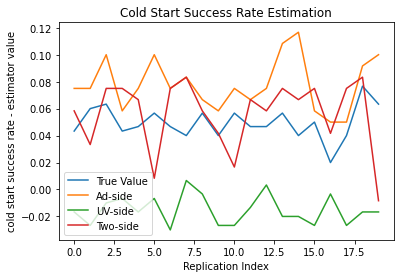

Ad-side Estimator: Ttest_relResult(statistic=7.523172424672059, pvalue=4.1238387970752623e-07)
UV-side Estimator: Ttest_relResult(statistic=-16.516830027660703, pvalue=9.99564032316962e-13)
Two-side Estimator: Ttest_relResult(statistic=0.9753086419753088, pvalue=0.34166213710543036)


In [29]:
plt.plot(np.array(true_cs_value), label='True Value')
plt.plot(np.array(ad_side_cs_estimator), label='Ad-side')
plt.plot(np.array(uv_side_cs_estimator), label='UV-side')
plt.plot(np.array(two_side_cs_estimator), label='Two-side')
plt.title('Cold Start Success Rate Estimation')
plt.xlabel('Replication Index')
plt.ylabel('cold start success rate - estimator value')
plt.legend()
plt.show()


# T test comparing estimators with true value
print('Ad-side Estimator:', stats.ttest_rel(ad_side_cs_estimator, true_cs_value))
print('UV-side Estimator:', stats.ttest_rel(uv_side_cs_estimator, true_cs_value))
print('Two-side Estimator:', stats.ttest_rel(two_side_cs_estimator, true_cs_value))

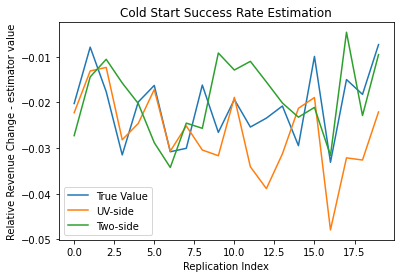

UV-side Estimator: Ttest_relResult(statistic=-3.224681938537936, pvalue=0.004460277269832853)
Two-side Estimator: Ttest_relResult(statistic=0.8959578536617966, pvalue=0.3814867073864382)


In [30]:
plt.plot(np.array(true_rev_value), label='True Value')
plt.plot(np.array(uv_side_rev_estimator), label='UV-side')
plt.plot(np.array(two_side_rev_estimator), label='Two-side')
plt.ylabel('Relative Revenue Change - estimator value')
plt.title('Cold Start Success Rate Estimation')
plt.xlabel('Replication Index')
plt.legend()
plt.show()
print('UV-side Estimator:',stats.ttest_rel(uv_side_rev_estimator, true_rev_value))
print('Two-side Estimator:',stats.ttest_rel(two_side_rev_estimator, true_rev_value))
